In [3]:
import sys
sys.executable

'/Users/cody/.virtualenvs/lau_lab/bin/python3.6'

In [4]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import NVR
import umap

In [5]:
from pydpc import Cluster
from pydpc._reference import Cluster as RefCluster

In [6]:
def normarcsinh(raw_counts,constant):
    sumValue = np.sum(raw_counts, axis = 1)
    norm = raw_counts.div(sumValue.values, axis='rows')*constant
    out = np.arcsinh(norm)
    return out

In [7]:
def mask_percent(mask,counts):
    mask_sum = np.sum( counts.iloc[:,mask].values, axis=1)
    lib_sum = np.sum( counts.values, axis=1) #sum of all counts in any given cell
    mask_percent = mask_sum/lib_sum.astype(float)*100 #percent of counts that are mitochondrial given all counts in cell
    return mask_percent

In [8]:
def lib_size_metrics(counts,inflect_pt):
    """
    outputs: threshold_argsorted, top_n_counts,top_n_lib_sum
    """
    lib_sum = np.sum( counts.values, axis=1) #sum of all counts in any given cell
    argsorted=np.argsort(lib_sum)[::-1]
    threshold_argsorted = np.sort(np.where(argsorted<inflect_pt)).ravel()
    top_n_counts = counts.iloc[threshold_argsorted,:]
    top_n_lib_sum = np.sum(top_n_counts,axis=1)
    return threshold_argsorted,top_n_counts,top_n_lib_sum

In [9]:
def dim_reduc(arc_data_in,pcs,n_neighbors,min_dist):
    pca = PCA(n_components=pcs)
    X_pca = pca.fit(arc_data_in).transform(arc_data_in)
    X_umap = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,metric='correlation').fit_transform(X_pca)
    return X_pca,X_umap

In [10]:
def gating_function(embedding,counts,gate_out,cluster_membership):
    clust_inds = np.delete(np.arange(0,cluster_membership.shape[0],1),gate_out) # clusters that represent cells to keep
    clust_mask = np.isin(cluster_membership, clust_inds)
    gated_embedding = embedding[clust_mask]
    gated_counts = counts[clust_mask] # gated cell data
    return gated_embedding,gated_counts

## Data Import from hdf5

In [11]:
dataIn=h5py.File("inputs/Adj-Norm-1291-AS1.h5","r")

In [12]:
list(dataIn.keys())

['counts_0', 'transcripts_0']

In [13]:
countsIn=pd.DataFrame(dataIn['counts_0'].value)
transcriptsIn=pd.DataFrame(dataIn['transcripts_0'].value)
colIn=list(transcriptsIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
countsIn.columns=colIn
count_names = countsIn.columns

In [14]:
dataIn.close()

## Mask making

In [15]:
mt_mask = pd.Series( count_names).str.startswith( 'mt').values # startswith() is case sensitive
immune_mask = pd.Series( count_names).str.contains(('Cd[0-9]{1,1}[a-z]$')).values # startswith() is case sensitive
blood_mask = pd.Series( count_names).str.startswith(("Hbb","Hba")).values # startswith() is case sensitive

## Calculating mito count percentage

In [16]:
# get total mito counts for each cell
cell_mt_sum = np.sum( countsIn.iloc[:,mt_mask].values, axis=1)
# get summed counts for all genes in any given cell
lib_sizes   = np.sum( countsIn.values, axis=1) #sum of all counts in any given cell
pert_mito   = cell_mt_sum/lib_sizes.astype(float)*100 #percent of counts that are mitochondrial given all counts in cell

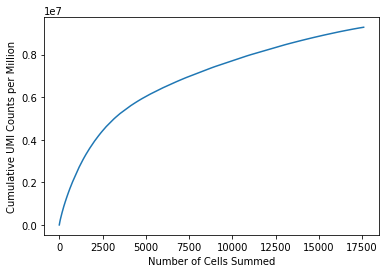

In [17]:
plt.ylabel( 'Cumulative UMI Counts per Million')
plt.xlabel( 'Number of Cells Summed')
plt.plot(np.cumsum(lib_sizes))

## Selection of top n cells based on inflection point

In [18]:
#Just take 2500 for now and gate out the lower quality cells later

In [19]:
inflect_pt=5000 #just multiply the inflection point by 2 #Get a number of cells near where the elbow appears to be, generous threshold 

In [20]:
ranking,topcounts,toplibsum=lib_size_metrics(countsIn,inflect_pt)

In [21]:
mito_percent=mask_percent(mt_mask,topcounts)
blood_percent=mask_percent(blood_mask,topcounts)
immune_percent=mask_percent(immune_mask,topcounts)

In [22]:
arc_data_df=normarcsinh(topcounts,1000)

## Dimensionality reductions and visualization

In [23]:
np.random.seed(42)

In [24]:
pca0,umap0=dim_reduc(arc_data_df,100,15,.3)

In [25]:
umap0=umap0.astype('float64')

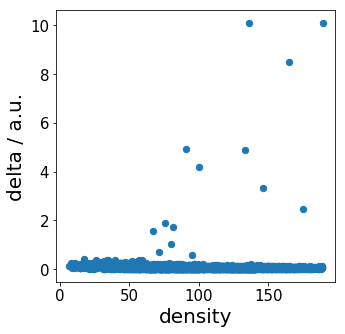

In [26]:
clu0 = Cluster(umap0)

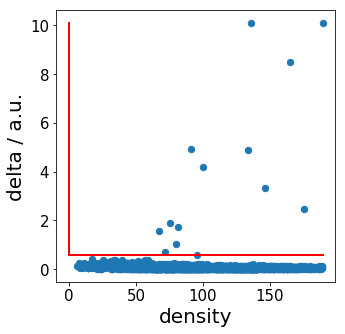

In [27]:
clu0.assign(0,.6) #try to include as many as possible

In [28]:
unique, membercounts = np.unique(clu0.membership, return_counts=True)

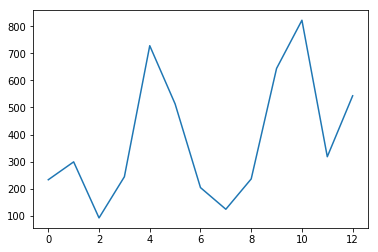

In [29]:
plt.plot(membercounts)

Text(0.5, 0, 'embedding-Clca1')

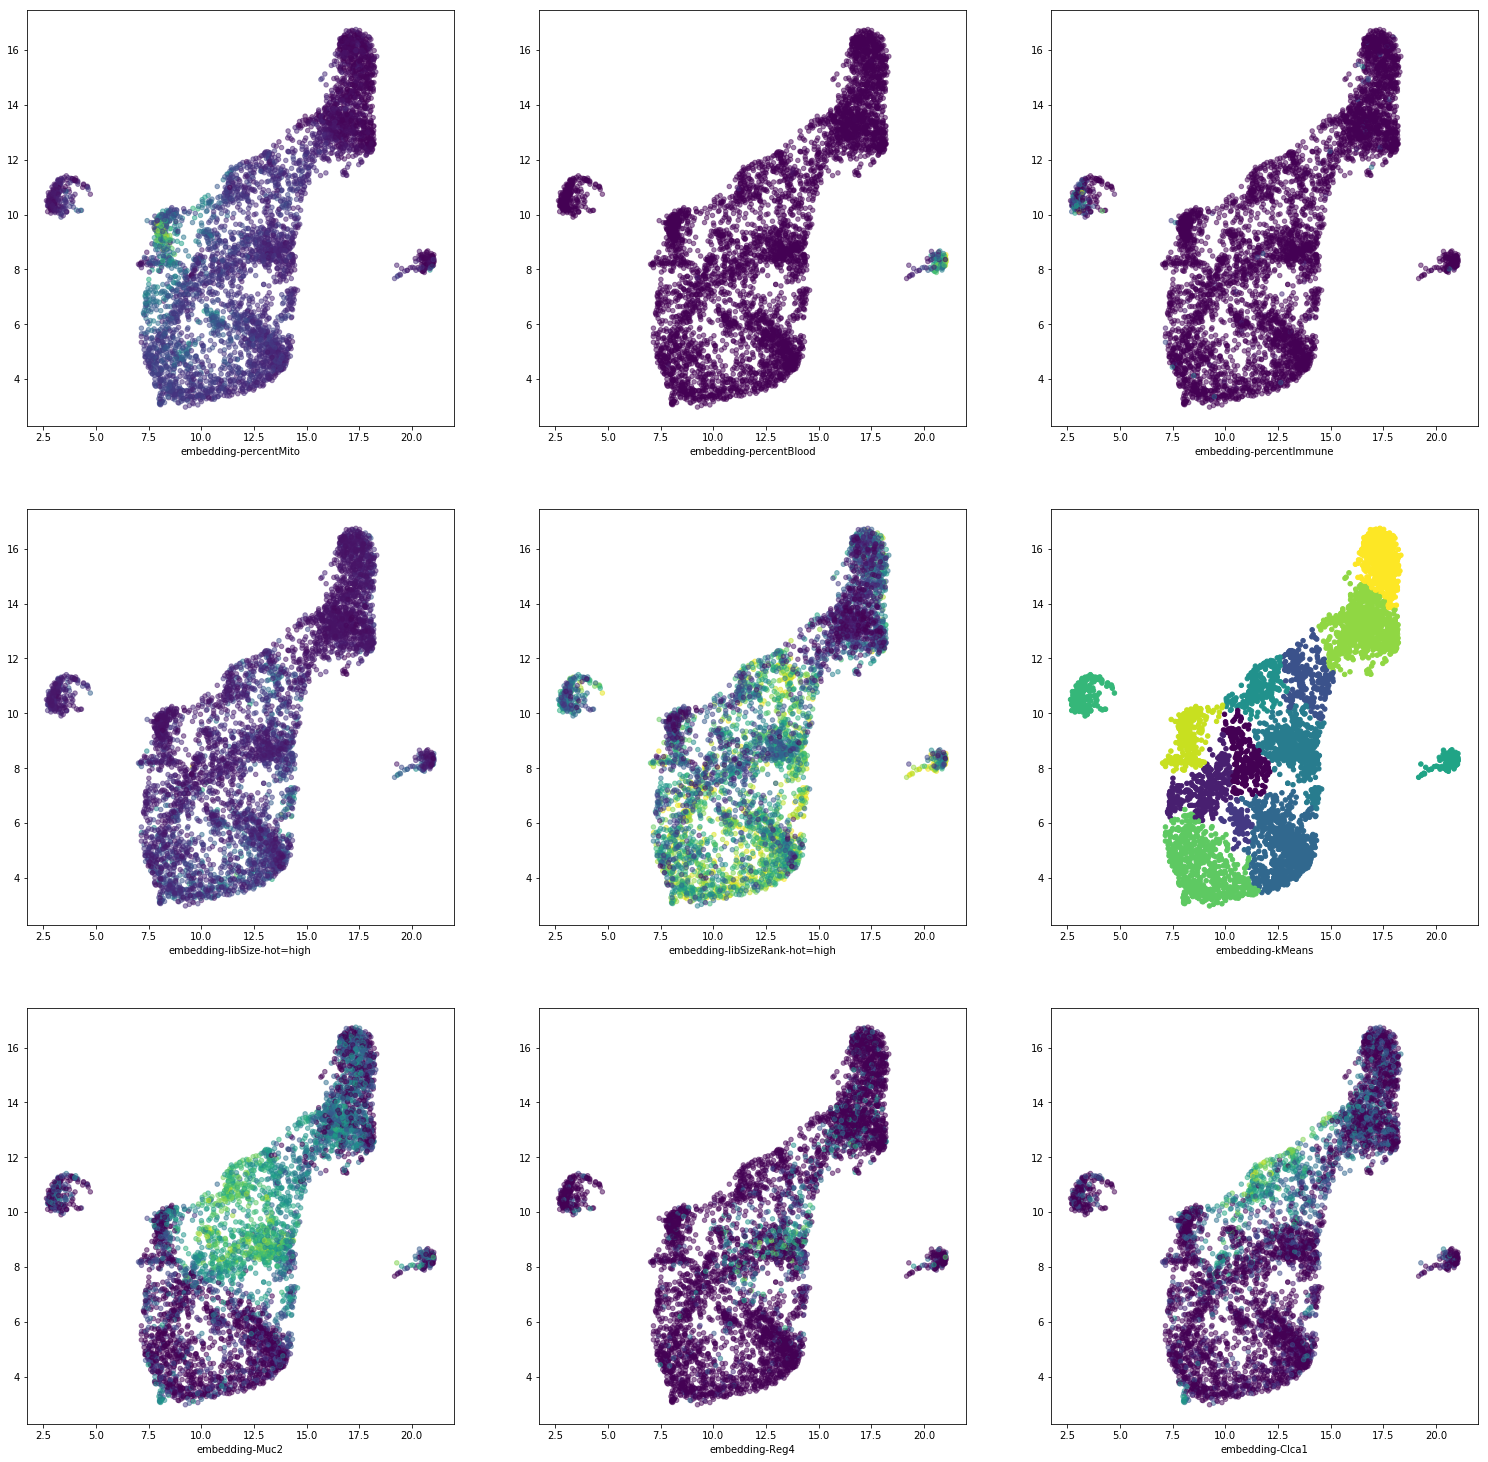

In [30]:
embedding=umap0

fig=plt.figure(figsize=(26,26))
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)

ax1.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=mito_percent)
ax2.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=blood_percent)
ax3.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=immune_percent)
ax4.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=toplibsum)
ax5.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=np.argsort(ranking)[::-1])
ax6.scatter( embedding[:,0], embedding[:,1], alpha=1, s=20, c=clu0.membership)
ax7.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=arc_data_df['Muc2'])
ax8.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=arc_data_df['Reg4'])
ax9.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=arc_data_df['Clca1'])

ax1.set_xlabel( "embedding-percentMito")
ax2.set_xlabel( "embedding-percentBlood")
ax3.set_xlabel( "embedding-percentImmune")
ax4.set_xlabel( "embedding-libSize-hot=high")
ax5.set_xlabel( "embedding-libSizeRank-hot=high")
ax6.set_xlabel( "embedding-kMeans")
ax7.set_xlabel( "embedding-Muc2")
ax8.set_xlabel( "embedding-Reg4")
ax9.set_xlabel( "embedding-Clca1")

## Cell gating

Text(0.5, 0, 'umap-dpcluster')

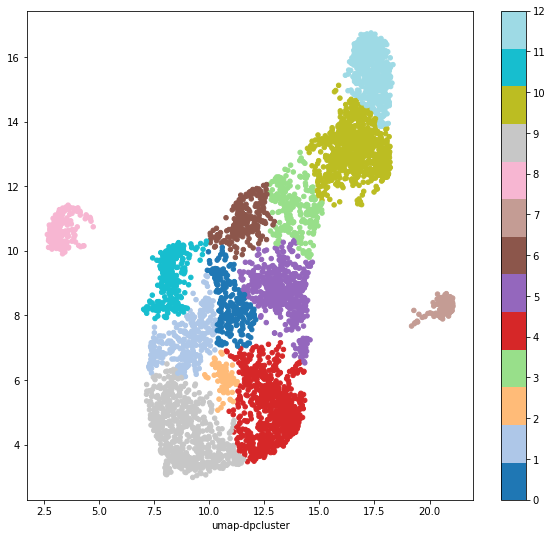

In [32]:
cmap=plt.cm.get_cmap('tab20', unique.shape[0])
fig=plt.figure(figsize=(10,9))
ax1=plt.scatter( embedding[:,0], embedding[:,1], alpha=1, s=20, c=clu0.membership, cmap=cmap)#np.argsort(good_lib_sizes)[::-1])
plt.colorbar(ticks=range(unique.shape[0]))
plt.xlabel( "umap-dpcluster")

In [33]:
#gate out 14,13 for immune and blood, 15 for library size, 12 for mito, 3 looks weird

In [34]:
gate_out=[11,10,8,5,7,4]

In [35]:
clu0.membership.shape[0]

5000

In [36]:
gated_umap0,gated_topcounts=gating_function(umap0,topcounts,gate_out,clu0.membership)

In [37]:
ranking1,topcounts1,toplibsum1=lib_size_metrics(gated_topcounts,gated_topcounts.shape[0])

In [38]:
mito_percent1=mask_percent(mt_mask,topcounts1)
blood_percent1=mask_percent(blood_mask,topcounts1)
immune_percent1=mask_percent(immune_mask,topcounts1)

In [39]:
arc_data_df1=normarcsinh(topcounts1,1000)

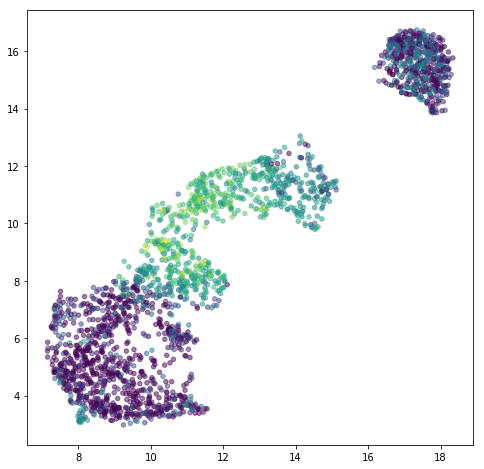

In [40]:
#do a quick check to show that the correct clusters got gated out
plt.figure(figsize=(8,8))
plt.scatter( gated_umap0[:,0], gated_umap0[:,1], alpha=0.5, s=20, c=arc_data_df1['Muc2'])

In [41]:
pca1,umap1=dim_reduc(arc_data_df1,100,15,.3)

In [ ]:
embedding=umap1

fig=plt.figure(figsize=(26,26))
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)

ax1.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=mito_percent1)
ax2.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=blood_percent1)
ax3.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=immune_percent1)
ax4.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=toplibsum1)
ax5.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=np.argsort(ranking1)[::-1])
#ax6.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=clu0.membership)
ax7.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=arc_data_df1['Muc2'])
ax8.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=arc_data_df1['Reg4'])
ax9.scatter( embedding[:,0], embedding[:,1], alpha=0.5, s=20, c=arc_data_df1['Clca1'])

ax1.set_xlabel( "embedding-percentMito")
ax2.set_xlabel( "embedding-percentBlood")
ax3.set_xlabel( "embedding-percentImmune")
ax4.set_xlabel( "embedding-libSize-hot=high")
ax5.set_xlabel( "embedding-libSizeRank-hot=high")
ax6.set_xlabel( "embedding-kMeans")
ax7.set_xlabel( "embedding-Muc2")
ax8.set_xlabel( "embedding-Reg4")
ax9.set_xlabel( "embedding-Clca1")

In [ ]:
umap1.shape

In [ ]:
cmap=plt.cm.get_cmap('seismic')
fig=plt.figure(figsize=(20,9))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
mito=ax1.scatter( umap1[:,0], umap1[:,1], alpha=1, s=20, c=mito_percent1,cmap=cmap)#np.argsort(good_lib_sizes)[::-1])
rank=ax2.scatter( umap1[:,0], umap1[:,1], alpha=1, s=20, c=np.argsort(ranking1)[::-1],cmap=cmap)#np.argsort(good_lib_sizes)[::-1])
plt.colorbar(mito,ax=ax1)
plt.colorbar(rank,ax=ax2)
plt.xlabel( "umap-mito")

In [ ]:
#low end cell number if inflection point set to double the inflection point

In [ ]:
#low end cell number if inflection point set to inflection point, no shape change

In [ ]:
#some kind of mito and library rank thresholding

In [ ]:
epithelial_data=topcounts1

In [ ]:
topcounts1.shape

In [ ]:
ranking2,topcounts2,toplibsum2=lib_size_metrics(topcounts1,1800)

In [ ]:
epithelial_data_2=topcounts2

In [ ]:
ranking3,topcounts3,toplibsum3=lib_size_metrics(topcounts1,1600)

In [ ]:
epithelial_data_3=topcounts3

## Writing to file

In [ ]:
libOut=h5py.File("Adj-Norm-1291-AS1-Gated-Epithelial-DPC-UMAP.hdf5","w")

In [ ]:
libOut.create_dataset("Counts_Epithelial_100",data=topcounts1,compression="gzip")

In [ ]:
libOut.create_dataset("Counts_Epithelial_70",data=topcounts2,compression="gzip")

In [ ]:
libOut.create_dataset("Counts_Epithelial_60",data=topcounts3,compression="gzip")

In [ ]:
#libOut.create_dataset("Unknown_Data_0",data=unknown_data_0,compression="gzip")

In [ ]:
#libOut.create_dataset("Unknown_Data_1",data=unknown_data_1,compression="gzip")

In [ ]:
transcripts_0=count_names

In [ ]:
transcripts=[names.encode('utf-8') for names in transcripts_0]

In [ ]:
libOut.create_dataset("Transcripts",data=transcripts,compression="gzip")

In [ ]:
libOut.close()